In [1]:
import torch
import os
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
from torchsummary import summary
from IPython.display import clear_output
from torch.utils.data import DataLoader
from torchvision.transforms.v2 import Compose, ToDtype, Normalize, Resize, PILToTensor
from sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from torch.utils.data import Dataset
from torchvision.transforms import v2
from collections import defaultdict
from sklearn.metrics import accuracy_score, f1_score
import csv
import pickle
from torch.optim import AdamW
from sklearn.model_selection import StratifiedShuffleSplit
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
class Data():
    def __init__(self, image_dir, train, transform):
        """
        image_dir: путь к папке с изображениями
        transform: torchvision трансформации
        """
        self.image_dir = image_dir
        self.transform = transform
        self.train = train
        self.le = LabelEncoder()

        # Список всех файлов с нужными расширениями
        self.image_files = [
            f for f in os.listdir(image_dir)
            if f.endswith('.jpg')
        ]

        if self.train:
            train_ans = pd.read_csv('D:\VSCode\YandexPrac\Liceu\\train_answers.csv',sep=";")
            label_map = dict(zip(train_ans['img_id'].values, train_ans['target_feature'].values))
            
            # Преобразуем метки в плотный диапазон 0-15
            original_labels = list(label_map.values())
            encoded_labels = self.le.fit_transform(original_labels)
            self.label_map = dict(zip(label_map.keys(), encoded_labels))
        
    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)

        # Загружаем изображение
        image = Image.open(img_path)
        image = self.transform(image)
            
        # Определяем метку по имени файла
        if self.train:
            label = self.label_map[int(img_name.split('.')[0])]
            return image, label
        else:
            return image

In [4]:
transform = Compose([
    Resize((128, 227)),
    PILToTensor(),
    ToDtype(torch.float32, scale=True),
    Normalize((0.5, 0.5, 0.5), (0.25, 0.25, 0.25)),
    # RandomAutocontrast(p=1.0),
])

train_data = Data(image_dir="D:\VSCode\YandexPrac\Liceu\img_train",
                 train=True,
                 transform=transform)

with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(train_data.le, f)

test_set = Data(image_dir="D:\VSCode\YandexPrac\Liceu\img_test",
                 train=False,
                 transform=transform)

# Стратифицированное разделение
labels = [train_data.label_map[int(img_name.split('.')[0])] for img_name in train_data.image_files]
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
train_indices, valid_indices = next(splitter.split(np.zeros(len(labels)), labels))

train_set = torch.utils.data.Subset(train_data, train_indices)
valid_set = torch.utils.data.Subset(train_data, valid_indices)


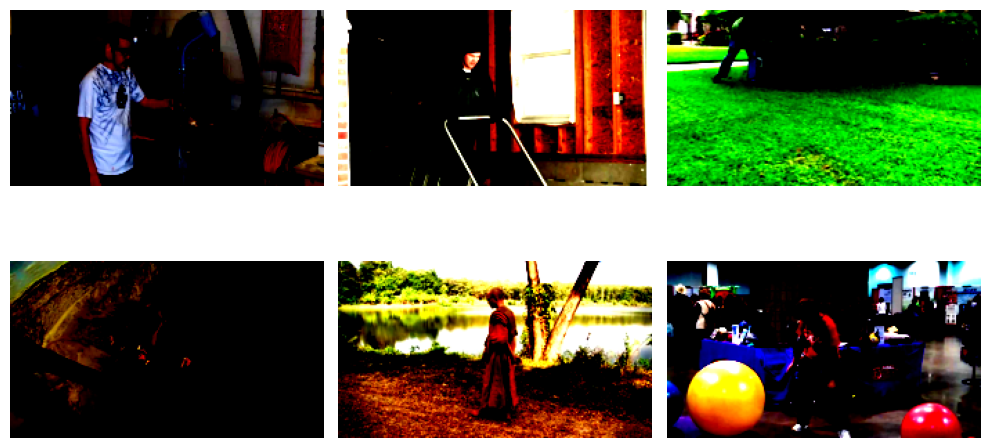

In [5]:
def show_dataset_images(dataset, num_images=6, cols=3):
    rows = (num_images + cols - 1) // cols
    plt.figure(figsize=(10, 6))
    
    for i in range(num_images):
        value = np.random.randint(len(dataset))
        image, _ = dataset[value]
        
        image = image.numpy()
        image = np.transpose(image, (1, 2, 0))
        image = np.clip(image, 0, 1)
        
        plt.subplot(rows, cols, i+1)
        plt.imshow(image)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_dataset_images(train_data, num_images=6)

In [6]:
class BalancedDataset(Dataset):
    def __init__(self, original_dataset):
        self.original_dataset = original_dataset
        
        self.class_indices = defaultdict(list)
        for i, (_, label) in enumerate(original_dataset):
            self.class_indices[label].append(i)
        
        self.all_indices = []
        self.is_augmented = []
        
        self.augmentations = [
            v2.RandomHorizontalFlip(p=0.5),
            v2.RandomRotation(degrees=np.random.uniform(5, 15)),
            v2.ColorJitter(
                brightness=np.random.uniform(0.1, 0.3),
                contrast=np.random.uniform(0.1, 0.3),
                saturation=np.random.uniform(0.1, 0.3),
                hue=np.random.uniform(0.05, 0.15)
            ),
            v2.RandomAffine(degrees=0, translate=(0.1, 0.1)),
            v2.RandomPerspective(distortion_scale=0.2, p=0.5),
        ]
        
        for label, indices in self.class_indices.items():
            current_count = len(indices)
    
            if current_count <= 400:
                needed = current_count * 3
            elif current_count <= 500:
                needed = current_count * 2
            elif current_count <= 1000:
                needed = current_count
            elif current_count <= 1200:
                needed = int(current_count * 0.5)
            else:
                needed = 0
            
            self.all_indices.extend([(idx, 0) for idx in indices])
            
            if needed > 0:
                aug_indices = np.random.choice(indices, size=needed, replace=True)
                self.all_indices.extend([(idx, 1) for idx in aug_indices])
    
    def __len__(self):
        return len(self.all_indices)
    
    def __getitem__(self, idx):
        original_idx, is_augmented = self.all_indices[idx]
        image, label = self.original_dataset[original_idx]
        
        if is_augmented:
            num_augs = np.random.randint(1, 4)
            selected_augs = list(np.random.choice(self.augmentations, size=num_augs, replace=False))
            transform = v2.Compose(selected_augs)
            image = transform(image)
        
        return image, label
    
balanced_train_set = BalancedDataset(train_set)

In [7]:
# def count_classes(dataset):
#     class_counts = defaultdict(int)
    
#     for i in range(len(dataset)):
#         _, label = dataset[i]
#         class_counts[label] += 1
    
#     print("Количество элементов по классам:")
#     for class_id in sorted(class_counts.keys()):
#         print(f"Класс {class_id}: {class_counts[class_id]} элементов")
    
#     plt.figure(figsize=(12, 6))
#     plt.bar(class_counts.keys(), class_counts.values())
#     plt.xlabel('Класс')
#     plt.ylabel('Количество элементов')
#     plt.title('Распределение элементов по классам')
#     plt.xticks(list(class_counts.keys()))
#     plt.grid(True)
#     plt.show()

# class_counts = count_classes(train_set)
# class_counts = count_classes(balanced_train_set)

In [7]:
BATCH_SIZE = 128

train_loader = DataLoader(balanced_train_set, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

In [16]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=16):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            # Conv1 (227x227x3 -> 55x55x96)
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(96),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 55x55x96 -> 27x27x96
            
            # Conv2 (27x27x96 -> 27x27x256)
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 27x27x256 -> 13x13x256
            
            # Conv3 (13x13x256 -> 13x13x384)
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            
            # Conv4 (13x13x384 -> 13x13x384)
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            
            # Conv5 (13x13x384 -> 13x13x256)
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=3, stride=2),  # 13x13x256 -> 6x6x256
            nn.AdaptiveAvgPool2d((6, 6))  # Гарантирует выход 6x6 независимо от входа
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            
            nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(4096),
            
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.classifier(x)
        return x

model = AlexNet(num_classes=16).to(device)
summary(model, (3, 128, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 30, 55]          34,944
              ReLU-2           [-1, 96, 30, 55]               0
       BatchNorm2d-3           [-1, 96, 30, 55]             192
         MaxPool2d-4           [-1, 96, 14, 27]               0
            Conv2d-5          [-1, 256, 14, 27]         614,656
              ReLU-6          [-1, 256, 14, 27]               0
       BatchNorm2d-7          [-1, 256, 14, 27]             512
         MaxPool2d-8           [-1, 256, 6, 13]               0
            Conv2d-9           [-1, 384, 6, 13]         885,120
             ReLU-10           [-1, 384, 6, 13]               0
      BatchNorm2d-11           [-1, 384, 6, 13]             768
           Conv2d-12           [-1, 384, 6, 13]       1,327,488
             ReLU-13           [-1, 384, 6, 13]               0
      BatchNorm2d-14           [-1, 384

In [17]:
def run_epoch(model, dataloader, loss_function, optimizer=None, device=None):
    """Выполняет одну эпоху обучения/валидации"""
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.train(mode=optimizer is not None)
    total_loss = 0.0
    all_preds, all_targets = [], []
    
    with torch.set_grad_enabled(optimizer is not None):
        for X, y in tqdm(dataloader, desc=f"{'Training' if optimizer else 'Evaluating'}"):
            X, y = X.to(device), y.to(device)
            
            pred = model(X)
            loss = loss_function(pred, y)
            total_loss += loss.item()
            
            if optimizer is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            else:
                all_preds.extend(pred.argmax(dim=1).cpu().numpy())
                all_targets.extend(y.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader)  # Вычисляем вне условий
    
    if optimizer is None:
        acc = accuracy_score(all_targets, all_preds)
        f1_val = f1_score(all_targets, all_preds, average='macro')
        return avg_loss, acc, f1_val
    
    return avg_loss, None, None  # Всегда возвращаем avg_loss

In [18]:
def show_losses(train, val, acc, f1):
    clear_output()
    plt.figure(figsize=(12,4))
    
    PAST_EPOCHS = len(train)
    
    plt.subplot(1, 3, 1)
    plt.title("Loss values")
    plt.plot(np.arange(PAST_EPOCHS), train, color="b", label=f'Train Loss = {train[-1]}')
    plt.plot(np.arange(PAST_EPOCHS), val, color="orange", label=f'Val Loss = {val[-1]}')
    plt.yscale('log')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 2)
    plt.title("Accuracy")
    plt.plot(np.arange(PAST_EPOCHS), acc, color="orange", label=f'Acuracy = {acc[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.title("F1 score")
    plt.plot(np.arange(PAST_EPOCHS), f1, color="orange", label=f'F1 = {f1[-1]}')
    plt.xticks(np.arange(PAST_EPOCHS))
    plt.grid()

    plt.tight_layout()
    plt.show()

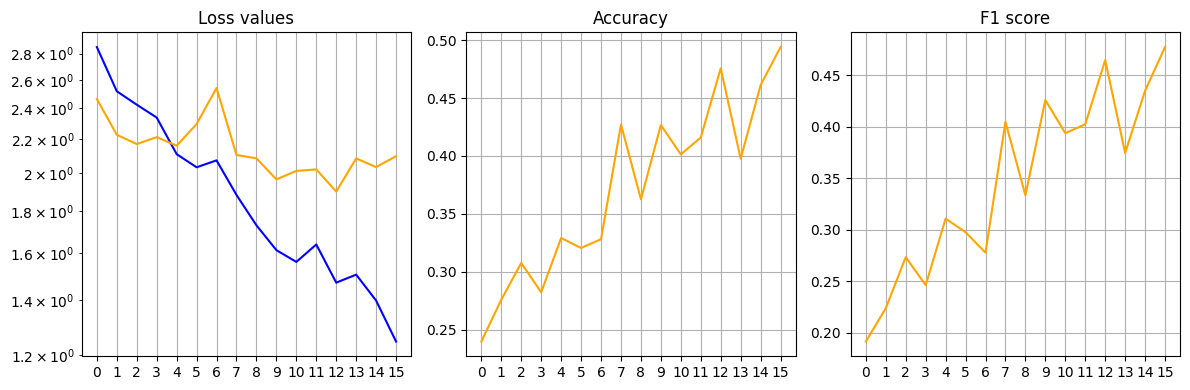

Training:  14%|█▍        | 23/167 [01:53<11:50,  4.94s/it]


KeyboardInterrupt: 

In [19]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
NUM_EPOCHS = 50

# Инициализация модели и оптимизатора
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-3,
    betas=(0.9, 0.999),    # β₁ задаёт аналог momentum
    weight_decay=1e-4
)

# Инициализация scheduler
scheduler = ReduceLROnPlateau(
    optimizer, 
    mode='max',   
    factor=0.5,   
    patience=5,   
    verbose=True,  
    min_lr=1e-6   
)

train_loss_hist = []
test_loss_hist = []
accuracy = []
f1 = []
best_f1 = -np.inf  

for epoch in range(NUM_EPOCHS):
    train_loss, _, _ = run_epoch(model, train_loader, loss_function, optimizer, device)
    train_loss_hist.append(train_loss)
    
    with torch.no_grad():
        test_loss, acc, f1_val = run_epoch(model, valid_loader, loss_function, None, device)
        test_loss_hist.append(test_loss)
        accuracy.append(acc)
        f1.append(f1_val)
    
    scheduler.step(f1[-1])  
    
    if f1[-1] > best_f1:
        best_f1 = f1[-1]
        torch.save(model, 'model4_16_best_model.pth')
        torch.save(model.state_dict(), 'model4_16_best_weights.pth')
    
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch+1}/{NUM_EPOCHS} | LR: {current_lr:.2e}")
    
    show_losses(train_loss_hist, test_loss_hist, accuracy, f1)

print(f"\nBest results:")
print(f"Min loss: {min(test_loss_hist):.4f}")
print(f"Max Accuracy: {max(accuracy):.4f}")
print(f"Max F1: {best_f1:.4f}")

In [67]:
def predict(model, dataloader):
    y_true, y_pred = [], []

    model.eval()
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to('cpu')
            
            y_true += list(y)
            y_pred += list(torch.argmax(model(X), dim=1).cpu())
    return y_true, y_pred 

In [ ]:
from sklearn.metrics import classification_report
model = torch.load('best_model.pth', weights_only=False)
model.load_state_dict(torch.load('best_model_weights.pth'))
model = model.to(device)

y_true, y_pred = predict(model, valid_loader)
print(classification_report(y_true, y_pred))

100%|██████████| 15/15 [00:45<00:00,  3.00s/it]

              precision    recall  f1-score   support

           0       0.79      0.63      0.70       377
           1       0.35      0.35      0.35        79
           2       0.40      0.47      0.43        80
           3       0.56      0.55      0.56       252
           4       0.67      0.73      0.69       113
           5       0.54      0.74      0.63       147
           6       0.65      0.64      0.64       120
           7       0.69      0.75      0.72        80
           8       0.73      0.61      0.67       184
           9       0.45      0.61      0.52        79
          10       0.75      0.77      0.76        70
          11       0.26      0.26      0.26        66
          12       0.61      0.56      0.58        34
          13       0.57      0.64      0.60       113
          14       0.88      0.68      0.76        62

    accuracy                           0.61      1856
   macro avg       0.59      0.60      0.59      1856
weighted avg       0.63   

In [ ]:
model = torch.load('model4_16_best_model.pth', weights_only=False)
model.load_state_dict(torch.load('model4_16_best_weights.pth'))
model = model.to(device)

for epoch in range(NUM_EPOCHS):
    train_loss, _, _ = run_epoch(model, train_loader, loss_function, optimizer, device)
    train_loss_hist.append(train_loss)
    
    with torch.no_grad():
        test_loss, acc, f1_val = run_epoch(model, valid_loader, loss_function, None, device)
        test_loss_hist.append(test_loss)
        accuracy.append(acc)
        f1.append(f1_val)
    
    scheduler.step(f1[-1])  
    
    if f1[-1] > best_f1:
        best_f1 = f1[-1]
        torch.save(model, 'model4_16_best_model.pth')
        torch.save(model.state_dict(), 'model4_16_best_weights.pth')
    
    current_lr = optimizer.param_groups[0]['lr']
    
    
    show_losses(train_loss_hist, test_loss_hist, accuracy, f1)

print(f"\nBest results:")
print(f"Min loss: {min(test_loss_hist):.4f}")
print(f"Max Accuracy: {max(accuracy):.4f}")
print(f"Max F1: {best_f1:.4f}")

Training:   2%|▏         | 4/167 [00:23<16:07,  5.93s/it]


KeyboardInterrupt: 

In [60]:
model = torch.load('best_model.pth', weights_only=False)
model.load_state_dict(torch.load('best_model_weights.pth'))
model = model.to(device)

y_true, y_pred = predict(model, valid_loader)
print(classification_report(y_true, y_pred))

AttributeError: 'collections.OrderedDict' object has no attribute 'load_state_dict'

In [61]:
model = torch.load('model4_16_best_model.pth', weights_only=False)
model.load_state_dict(torch.load('model4_16_best_weights.pth'))
model = model.to(device)
model.eval()

with open('label_encoder.pkl', 'rb') as f:
    le = pickle.load(f)

# Подготовка для сохранения предсказаний
test_preds = []
test_ids = []

# Предсказание на тестовых данных
with torch.no_grad():
    for img_name in tqdm(test_set.image_files, desc="Processing test images"):
        img_path = os.path.join(test_set.image_dir, img_name)
        image = Image.open(img_path)
        image = test_set.transform(image).unsqueeze(0).to(device)  # Добавляем batch dimension
        
        output = model(image)
        _, pred = torch.max(output, 1)
        
        test_ids.append(img_name.split('.')[0])  # Извлекаем ID без расширения
        test_preds.append(pred.item())

original_labels = le.inverse_transform(test_preds)

# Сортируем по ID (если нужно)
test_ids, test_preds = zip(*sorted(zip(test_ids, original_labels), key=lambda x: int(x[0])))

# Сохраняем в CSV
with open('submission.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow(['id', 'target_feature'])
    writer.writerows(zip(test_ids, test_preds))

print(f"Predictions saved to submission.csv, total {len(test_preds)} predictions")

Processing test images: 100%|██████████| 5301/5301 [06:31<00:00, 13.55it/s]


Predictions saved to submission.csv, total 5301 predictions
